Import External libraries

In [4]:
import numpy as np
from numpy import sin
from numpy import cos
import matplotlib.pyplot as plt 
import keplers

Define Global Constants

In [5]:
#%% Define program constants
# chosen astral body : Earth
G = 6.67e-11          # universal gravitational constant - m³/kg*s²
M = 5.972e24          # earth mass - kg
r_earth = 6379        # earth radius - km
mu = G * M * 10 ** -9 # earth gravitaional parameter - km³/s²

# initialise spacecraft parameters
BC = 0.00000229         # ballistic coefficient
m = 10000                # spacecraft mass - kg
altitude0 = 100          # spacecraft initial altitude - km
[e, a, i, RAAN, omega, M0] = [0, altitude0 + r_earth, 0, 0, 0, 0]
M0 = np.deg2rad(M0)

Functions

In [9]:
def atmos(r):
    # A function to find the density of air at various altitudes
    
    # re-scaling
    altitude = (r - r_earth) * 10 ** 3
    
    # define constants for atmosphere model
    p0 = 101325 # sea level atmospheric pressure Pa
    T0 = 288.15 # sea level atmospheric temperature K
    g = 9.80665 # earth surface gravitational acceleration m/s²
    R = 8.31446 # ideal gas constant J/mol*K
    M = 0.02897 # molar mass of dry air kg/mol
    
    # altitude upper limit levels
    troposphere = 11 * 10 ** 3
    tropopause = 20 * 10 ** 3
    stratosphere1 = 32 * 10 ** 3
    stratosphere2 = 47 * 10 ** 3
    stratopause = 51 * 10 ** 3
    mesosphere = 71 * 10 ** 3
    mesopause = 120 * 10 ** 3
    
    if altitude <= troposphere:
        # constants within the troposphere
        L = 0.0065  # temperature lapse rate K/m
    
        # governing equations
        T = T0 - (L * altitude)
        p = p0 * (1 - ((L*altitude)/T0)) ** (g*M/R*L)
        rho = (p * M)  / (R * T)
        
    elif troposphere < altitude <= tropopause :
        rho = (((altitude - troposphere)/(tropopause - troposphere))*(0.08803 - 0.36391)) + 0.36391

    elif tropopause < altitude <= stratosphere1 :
        rho = (((altitude - tropopause)/(stratosphere1 - tropopause))*(0.01322 - 0.08803)) + 0.08803
        
    elif stratosphere1 < altitude <= stratosphere2 :
        rho = (((altitude - stratosphere1)/(stratosphere2 - stratosphere1))*(0.00143 - 0.01322)) + 0.01322
        
    elif stratosphere2 < altitude <= stratopause :
        rho = (((altitude - stratosphere2)/(stratopause - stratosphere2))*(0.00086 - 0.00143)) + 0.00143
        
    elif stratopause < altitude <= mesosphere :
        rho = (((altitude - stratopause)/(mesosphere - stratopause))*(0.000064 - 0.00086)) + 0.00086
        
    elif mesosphere < altitude <= mesopause :
        rho = (((altitude - mesosphere)/(mesopause - mesosphere))*(0 - 0.000064)) + 0.000064
        
    elif mesopause < altitude :
        rho = 0

    return rho

def gravity(r, lat):
    # computes the acceleration due to gravity towards the planetary center and north, including the J2,3 and 4 perturbations
    
    phi = np.pi / (2 - lat)
    J2 = 1.08263e-3
    J3 = 2.532152e-7
    J4 = 1.6109876e-7

    gc = mu * (1 - (1.5 * J2 * ((3*cos(phi)**2) - 1) * (r_earth/r)**2) - (2 * J3 * cos(phi) * ((5*cos(phi)**2) - 3) * (r_earth/r)**3) - ((5/8) * J4 * ((35*cos(phi)**4) - (30*cos(phi)**2) + 3) * (r_earth/r)**4)) / (r**2)
    gnorth = 3 * mu * sin(phi) * cos(phi) * (r_earth/r) * (r_earth/r) * (J2 + (0.5*J3*((5*cos(phi)**2)-1)*(r_earth/r)/cos(phi) + ((5/6)*J4*((7*cos(phi)**2)-1)*(r_earth/r)**2)))/r**2

    return [gc, gnorth]

def period(a):
    # computes the keplerian period of an orbit at a specific orbit radius - s
    return 2 * np.pi * np.sqrt(a**3 / mu)

def velocity(r, a):
    # computes the orbital velocity at a specific orbit radius - km/s
    return np.sqrt(mu * ((2/r) - (1/a)))

def accel_drag(r, a):
    # computes the deceleration due to atmospheric drag at a specific orbit radius - km/s²
    return -BC * 0.5 * atmos(r) * velocity(r, a) ** 2

def drdt(r, a):
    # calculates the change in orbital radius due to atmospheric drag
    return accel_drag(r, a) * period(a) / np.pi;

Main Program

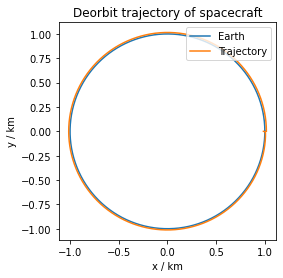

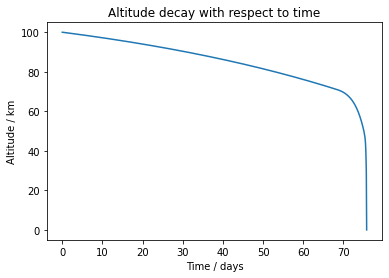

In [7]:
if __name__ == "__main__":
    
    #%%% Import libraries
    import matplotlib.pyplot as plt
    
    #%%% Define functions
    def plotter(dr, dt):
        
        # Define earth to plot
        r = 1
        theta = np.linspace(0, 2*np.pi, 1000)
        x_e = r * cos(theta)
        y_e = r * sin(theta)
        
        # calculating (x,y) coordinates of deorbit trajectory
        timescale = np.linspace(0, dt * len(dr), len(dr)) / (3600 * 24)
        x = np.zeros(len(dr))
        y = np.zeros(len(dr))
        nu = np.linspace(0, 2*np.pi, len(dr))
        for i in range(len(dr)):
            x[i] = (dr[i] / r_earth) * cos(nu[i])
            y[i] = (dr[i] / r_earth) * sin(nu[i])
        
        # plot
        fig = plt.figure()
        
        ax1 = fig.add_subplot()
        ax1.set_title('Deorbit trajectory of spacecraft')
        ax1.set_ylabel('y / km')
        ax1.set_xlabel('x / km')
        earth_plot, = plt.plot(x_e, y_e, label = 'Earth')
        trajectory, = plt.plot(x, y, label = 'Trajectory')
        ax1.legend(handles = [earth_plot, trajectory], loc = 'upper right')
        plt.axis('square')
        
        # reformatting data for plotting
        for i in range(len(dr)):
            dr[i] = dr[i] - r_earth
        dr[-1] = 0
        
        fig = plt.figure()
        
        ax2 = fig.add_subplot()
        ax2.set_title('Altitude decay with respect to time')
        ax2.set_ylabel('Altitude / km')
        ax2.set_xlabel('Time / days')
        plt.plot(timescale, dr)
        
        plt.show()
        
        return timescale
    
    #%%% Program
    mu = G * M * 10 ** -9
    dt = 3600   # timestep - hours
    n = np.sqrt(mu / a**3)
    
    # initialise solver parameters
    i = 0
    dr = [a]
    altitude = altitude0
    
    while altitude >= 0:
        
        # compute orbital period and mean motion
        T = period(a)
        n = 2 * np.pi / T
        
        # compute orbital radius
        M = M0 + (n * dt * i)
        E = keplers.solver(M, e)
        r = a * (1 - (e * cos(E)))
        
        # compute orbit decay rate
        decay_rate = drdt(r, a)
        decay_alt = decay_rate * dt
        
        # update orbit SMA, altitude, radius and time step
        a += decay_alt
        altitude = r - r_earth
        dr.append(r)
        i += 1
    
    timescale = plotter(dr, dt)